# Training the SPOCK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with generate_FC_data.ipynb

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'Tsecdata.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [3]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in short integration phase

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable'], test['instability_time']

We can then define the features of interest and dividing training and testing sets

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec']

trainX, trainY, testX, testY, testInstability = train_test(dataset, features)
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [5]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [6]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.9332908481088943                                     
ERROR                                                  
0.0028565470905989225                                  
SCORE:                                                                            
0.9332329327561976                                                                
ERROR                                                                             
0.002436194975349565                                                              
SCORE:                                                                            
0.93839300237411                                                                  
ERROR                                                                             
0.0026799081013746924                                                             
SCORE:                                                                            
0.9376204898186928           

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

# max_depth: depth of model trees

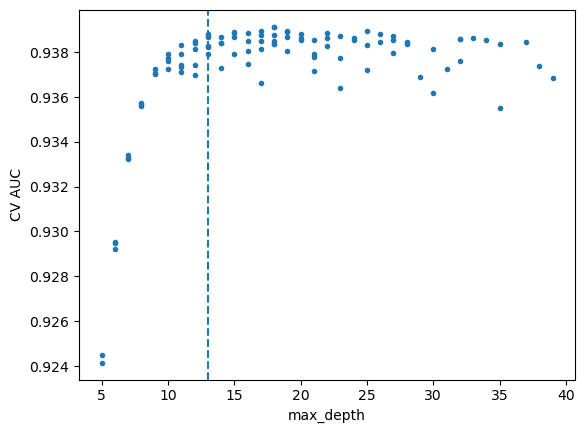

In [7]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')
ax.axvline(13, linestyle='--')

# min_child_weight: regulates model mitigating complexity 

Text(0, 0.5, 'CV AUC')

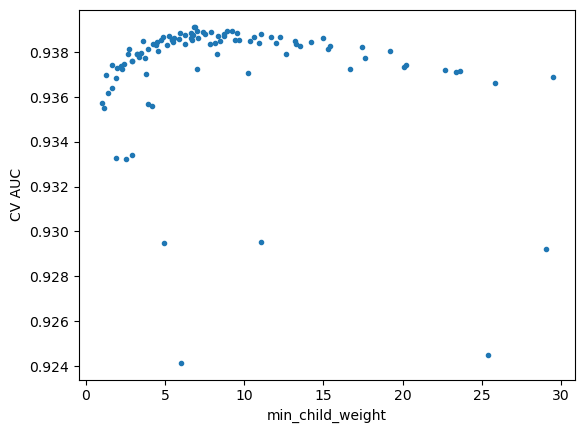

In [8]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

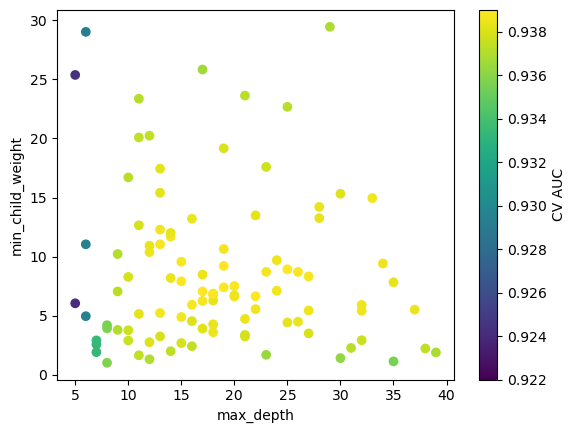

In [9]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs, vmin=0.922, vmax=0.939)
plt.colorbar(cb, label='CV AUC')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# max_depth =13, min_child_weight = 5

Minimum improvement when considering max depth or min child weight larger then 13 and 5 respectively.

In [10]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)


[0]	train-auc:0.95029+0.00056	test-auc:0.92247+0.00249
[1]	train-auc:0.95819+0.00067	test-auc:0.92985+0.00272
[2]	train-auc:0.96174+0.00073	test-auc:0.93398+0.00233
[3]	train-auc:0.96434+0.00043	test-auc:0.93653+0.00244
[4]	train-auc:0.96590+0.00051	test-auc:0.93808+0.00262
[5]	train-auc:0.96719+0.00049	test-auc:0.93918+0.00244
[6]	train-auc:0.96817+0.00047	test-auc:0.94007+0.00243
[7]	train-auc:0.96898+0.00035	test-auc:0.94061+0.00247
[8]	train-auc:0.96967+0.00039	test-auc:0.94102+0.00240
[9]	train-auc:0.97039+0.00034	test-auc:0.94143+0.00249
[10]	train-auc:0.97103+0.00028	test-auc:0.94177+0.00245
[11]	train-auc:0.97168+0.00026	test-auc:0.94217+0.00246
[12]	train-auc:0.97230+0.00027	test-auc:0.94258+0.00245
[13]	train-auc:0.97291+0.00024	test-auc:0.94291+0.00249
[14]	train-auc:0.97343+0.00024	test-auc:0.94317+0.00257
[15]	train-auc:0.97398+0.00028	test-auc:0.94352+0.00246
[16]	train-auc:0.97449+0.00027	test-auc:0.94375+0.00242
[17]	train-auc:0.97501+0.00028	test-auc:0.94406+0.00239
[1

# n_estimators (number of trees) tuning

Text(0, 0.5, 'CV AUC score')

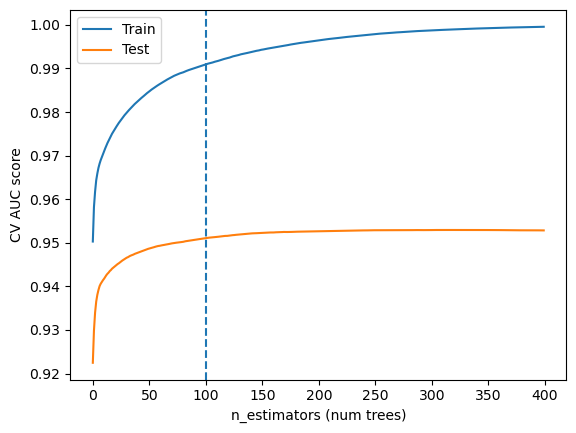

In [11]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Minimal improvement in testing AUC after 100 n_estimators

In [12]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
model.save_model('../spock/models/spock.json')

In [14]:
model = XGBClassifier()
model.load_model('../spock/models/spock.json')

# SPOCK feature classifier evaluation

**Define plotting helper functions**

In [15]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds
def stable_unstable_hist(model, testX, testy):
    preds = model.predict_proba(testX)[:,1]
    stablepreds = preds[np.where(testy==1)]
    unstablepreds = preds[np.where(testy==0)]
    return stablepreds, unstablepreds 

def calibration_plot(model, testX, testy, bins):
    
    preds = model.predict_proba(testX)[:,1]

    hist, edges = np.histogram(preds, bins=bins)

    bincenters = []
    fracstable = []
    errorbars = []
    for i in range(len(edges)-1):
        bincenters.append((edges[i]+edges[i+1])/2)
        mask = (preds >= edges[i]) & (preds < edges[i+1])
        nstable = testy[mask].sum()
        fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
        errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio. 
        # multiply the fractional error by value

    return np.array(bincenters), np.array(fracstable), np.array(errorbars)

def unstable_error_fraction(model, testX, testY, inst_times, thresh, bins=10, filter=False, filtertimes=False):
    preds = model.predict_proba(testX)[:,1]
    log_inst_times = np.log10(inst_times)
    
    unstable = log_inst_times < 8.99
    preds = preds[unstable]
    log_inst_times = log_inst_times[unstable]

    hist, edges = np.histogram(log_inst_times, bins=bins)

    bincenters = []
    errorfracs = []
    errorbars = []
    for i in range(len(edges)-1):
        bincenters.append((edges[i]+edges[i+1])/2)
        mask = (log_inst_times >= edges[i]) & (log_inst_times < edges[i+1])
        Nerrors = (preds[mask] > thresh).sum()
        errorfracs.append(Nerrors/hist[i])
        errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment

    return np.array(bincenters), np.array(errorfracs), np.array(errorbars)

# AUC and FPR

Text(0.5, 1.0, 'ROC curve (AUC = 0.950)')

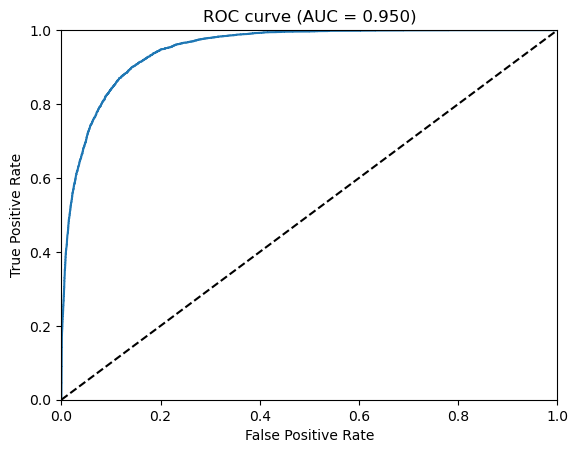

In [16]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [17]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
falsePos = fpr[tprthreshindex]
print(f"AUC: {roc_auc} \nFPR: {falsePos}")

AUC: 0.9501093299569734 
FPR: 0.14229084080951387


# Feature importance

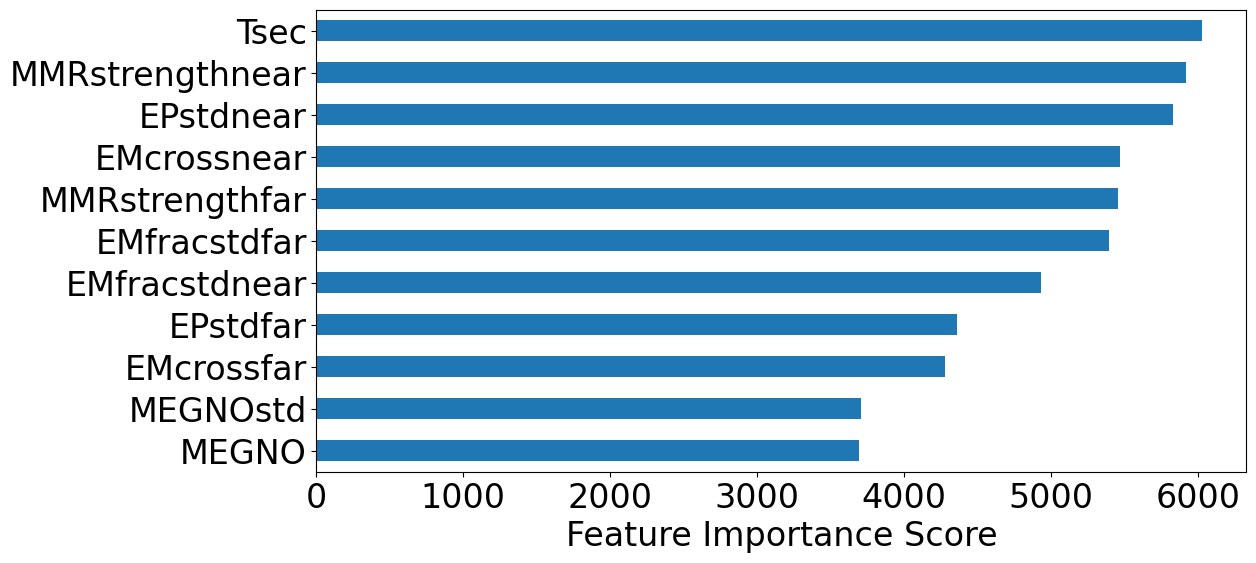

In [18]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# Performance histogram

(0.0, 430.1)

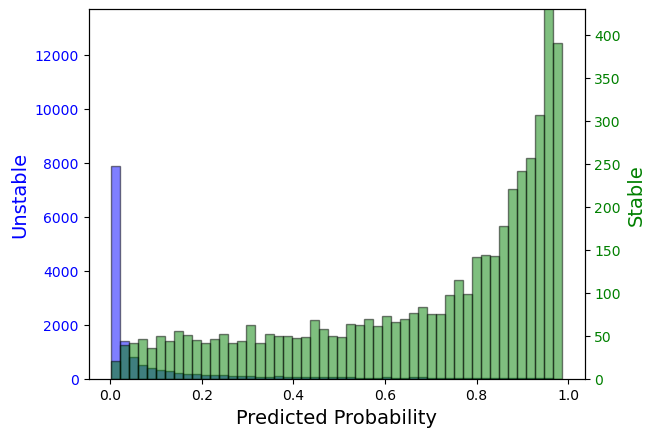

In [19]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(model, testX, testY)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

# Model performance and accuracy

Text(0, 0.5, 'Fraction actually stable')

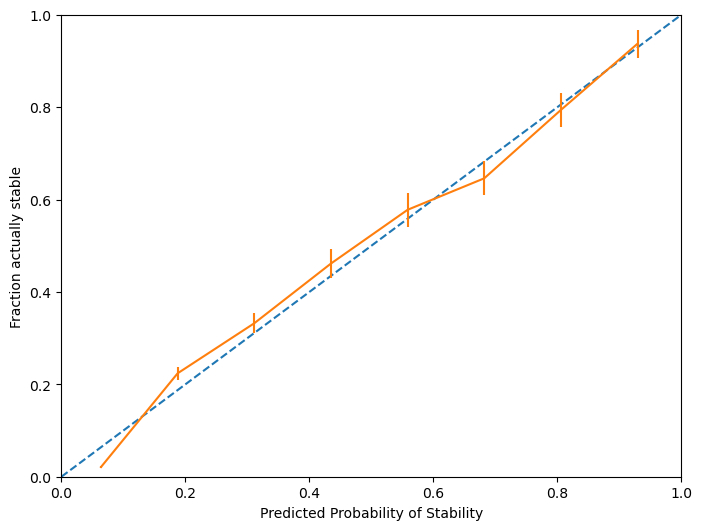

In [20]:
bincenters, fracstable, errorbars = calibration_plot(model, testX, testY, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')